In [1]:
import pandas as pd
import numpy as np 
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img,img_to_array
print(tf.__version__)

2.13.0


In [2]:
train_dir = Path('train')
train_filepaths = list(train_dir.glob(r'**/*.jpg'))

In [3]:
print(train_filepaths)

[WindowsPath('train/apple/Image_1.jpg'), WindowsPath('train/apple/Image_10.jpg'), WindowsPath('train/apple/Image_16.jpg'), WindowsPath('train/apple/Image_17.jpg'), WindowsPath('train/apple/Image_18.jpg'), WindowsPath('train/apple/Image_19.jpg'), WindowsPath('train/apple/Image_2.jpg'), WindowsPath('train/apple/Image_20.jpg'), WindowsPath('train/apple/Image_21.jpg'), WindowsPath('train/apple/Image_23.jpg'), WindowsPath('train/apple/Image_24.jpg'), WindowsPath('train/apple/Image_25.jpg'), WindowsPath('train/apple/Image_26.jpg'), WindowsPath('train/apple/Image_27.jpg'), WindowsPath('train/apple/Image_28.jpg'), WindowsPath('train/apple/Image_3.jpg'), WindowsPath('train/apple/Image_31.jpg'), WindowsPath('train/apple/Image_32.jpg'), WindowsPath('train/apple/Image_33.jpg'), WindowsPath('train/apple/Image_34.jpg'), WindowsPath('train/apple/Image_36.jpg'), WindowsPath('train/apple/Image_37.jpg'), WindowsPath('train/apple/Image_38.jpg'), WindowsPath('train/apple/Image_39.jpg'), WindowsPath('train

In [4]:
test_dir = Path('test')
test_filepaths = list(test_dir.glob(r'**/*.jpg'))

In [5]:
val_dir = Path('validation')
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

In [6]:
 str(train_filepaths[1]).split("\\")

['train', 'apple', 'Image_10.jpg']

In [7]:
def image_processing(filepath):

    
    labels = [str(filepath[i]).split("\\")[-2] \
              for i in range(len(filepath))]
    
    filepath = pd.Series(filepath, name='Filepath').astype(str)
    labels = pd.Series(labels, name='Label')
    
    df = pd.concat([filepath, labels], axis=1)
    
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

In [8]:
train_df = image_processing(train_filepaths)
test_df = image_processing(test_filepaths)
val_df = image_processing(val_filepaths)

In [9]:
print(f'Number of pictures: {train_df.shape[0]}\n')
print(f'Number of different labels: {len(train_df.Label.unique())}\n')
print(f'Labels {train_df.Label.unique()}')

Number of pictures: 2886

Number of different labels: 36

Labels ['pear' 'jalepeno' 'lemon' 'cabbage' 'turnip' 'potato' 'carrot'
 'soy beans' 'pomegranate' 'garlic' 'corn' 'peas' 'capsicum' 'bell pepper'
 'lettuce' 'onion' 'cucumber' 'chilli pepper' 'watermelon' 'sweetcorn'
 'eggplant' 'pineapple' 'sweetpotato' 'cauliflower' 'orange' 'paprika'
 'grapes' 'banana' 'kiwi' 'mango' 'apple' 'beetroot' 'tomato' 'raddish'
 'ginger' 'spinach']


In [10]:
train_df.head(5)

,Filepath,Label
0,train\pear\Image_97.jpg,pear
1,train\jalepeno\Image_41.jpg,jalepeno
2,train\lemon\Image_84.jpg,lemon
3,train\cabbage\Image_69.JPG,cabbage
4,train\turnip\Image_59.jpg,turnip


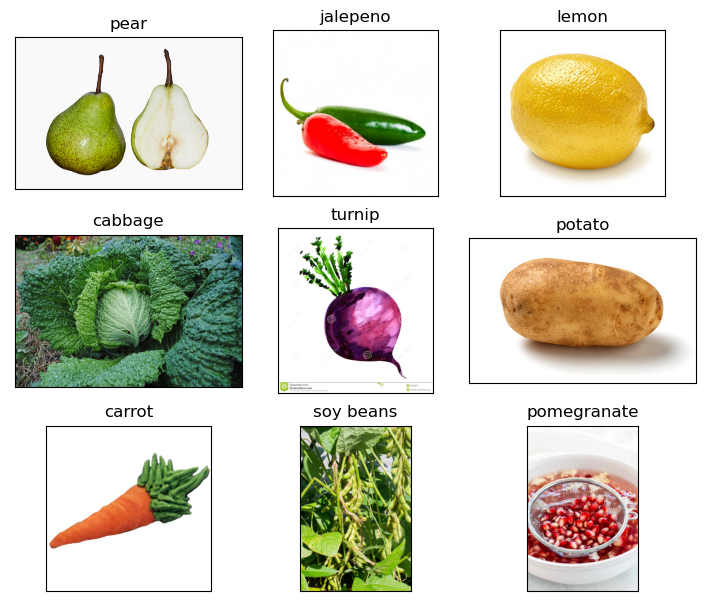

In [11]:
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(7, 6), 
                         subplot_kw={'xticks': [],'yticks': []})

for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    ax.set_title(df_unique.Label[i], fontsize = 12)
plt.tight_layout(pad=0.5)
plt.show()

In [12]:
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    preprocessing_function = tf.keras.applications.mobilenet_v2.preprocess_input
)

In [13]:
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 2886 validated image filenames belonging to 36 classes.


In [14]:
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=0,
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

Found 347 validated image filenames belonging to 36 classes.


In [15]:
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 345 validated image filenames belonging to 36 classes.


In [16]:
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)
pretrained_model.trainable = False

In [17]:
inputs = pretrained_model.input

x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)
x = tf.keras.layers.Dense(128, activation='relu')(x)

outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

model = tf.keras.Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history = model.fit(
    train_images,
    validation_data=val_images,
    batch_size = 32,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=2,
            restore_best_weights=True
        )
    ]
)

Epoch 1/20
91/91 [==============================] - 250s 3s/step - loss: 1.6897 - accuracy: 0.5530 - val_loss: 0.3625 - val_accuracy: 0.8790
Epoch 2/20
91/91 [==============================] - 204s 2s/step - loss: 0.5224 - accuracy: 0.8378 - val_loss: 0.3228 - val_accuracy: 0.8732
Epoch 3/20
91/91 [==============================] - 198s 2s/step - loss: 0.3304 - accuracy: 0.8929 - val_loss: 0.1627 - val_accuracy: 0.9424
Epoch 4/20
91/91 [==============================] - 201s 2s/step - loss: 0.2066 - accuracy: 0.9352 - val_loss: 0.1640 - val_accuracy: 0.9424
Epoch 5/20
91/91 [==============================] - 213s 2s/step - loss: 0.1495 - accuracy: 0.9560 - val_loss: 0.1551 - val_accuracy: 0.9424
Epoch 6/20
91/91 [==============================] - 210s 2s/step - loss: 0.1070 - accuracy: 0.9650 - val_loss: 0.1385 - val_accuracy: 0.9337
Epoch 7/20
91/91 [==============================] - 195s 2s/step - loss: 0.0840 - accuracy: 0.9712 - val_loss: 0.1075 - val_accuracy: 0.9539
Epoch 8/20
91

In [18]:
# Predict the label of the test_images
pred = model.predict(test_images)
pred = np.argmax(pred,axis=1)
# Map the label
labels = (train_images.class_indices)
labels = dict((v,k) for k,v in labels.items())
pred1 = [labels[k] for k in pred]
pred1

11/11 [==============================] - 31s 3s/step


['paprika',
 'paprika',
 'pear',
 'potato',
 'bell pepper',
 'peas',
 'cucumber',
 'watermelon',
 'pomegranate',
 'beetroot',
 'tomato',
 'capsicum',
 'eggplant',
 'chilli pepper',
 'carrot',
 'pineapple',
 'corn',
 'carrot',
 'watermelon',
 'beetroot',
 'pear',
 'bell pepper',
 'raddish',
 'carrot',
 'corn',
 'jalepeno',
 'pear',
 'onion',
 'kiwi',
 'jalepeno',
 'lettuce',
 'orange',
 'soy beans',
 'watermelon',
 'pomegranate',
 'cabbage',
 'capsicum',
 'sweetcorn',
 'apple',
 'paprika',
 'corn',
 'capsicum',
 'kiwi',
 'mango',
 'grapes',
 'spinach',
 'pineapple',
 'ginger',
 'apple',
 'apple',
 'cabbage',
 'capsicum',
 'kiwi',
 'carrot',
 'ginger',
 'cucumber',
 'sweetcorn',
 'pear',
 'spinach',
 'mango',
 'pomegranate',
 'cucumber',
 'cauliflower',
 'cabbage',
 'lettuce',
 'ginger',
 'cabbage',
 'grapes',
 'capsicum',
 'capsicum',
 'eggplant',
 'turnip',
 'garlic',
 'pear',
 'soy beans',
 'cabbage',
 'chilli pepper',
 'cauliflower',
 'onion',
 'orange',
 'potato',
 'cauliflower',
 '

In [19]:
def output(location):
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    print(answer)
    print(answer.max())
    print("bre")
    y_class = answer.argmax(axis=-1)
    print(y_class)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

1/1 [==============================] - 1s 1s/step
[[3.0517012e-06 9.3732291e-07 3.2381289e-10 2.8733260e-09 5.7036903e-11
  2.1641833e-07 1.3760154e-05 4.0490571e-09 5.9839449e-06 2.2882607e-07
  4.0862766e-08 5.5038635e-10 1.6753962e-08 1.1793834e-06 1.3550490e-09
  6.4264909e-09 3.7980536e-07 8.4153166e-05 1.0429991e-08 9.8529679e-04
  3.1367327e-07 5.9249508e-03 6.3515386e-06 3.4848148e-05 2.2022206e-08
  6.4950523e-06 4.1818794e-08 9.9292749e-01 2.5103063e-06 1.9127121e-07
  1.8838828e-11 5.3529913e-08 1.4165010e-06 2.3598229e-08 6.3194011e-10
  2.2711040e-08]]
0.9929275
bre
[27]
potato


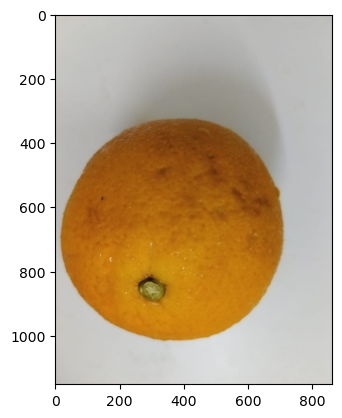

In [20]:
img = output('img24.jpg')
import matplotlib.image as mpimg
img2 = mpimg.imread('img24.jpg')
plt.imshow(img2)
print(img)

In [21]:
tf.keras.models.save_model(model, 'model.pbtxt')

converter = tf.lite.TFLiteConverter.from_keras_model(model=model)

model_tflite = converter.convert()

open("GrocRecogModel.tflite","wb").write(model_tflite)

INFO:tensorflow:Assets written to: model.pbtxt\assets


INFO:tensorflow:Assets written to: model.pbtxt\assets


INFO:tensorflow:Assets written to: C:\Users\yvonn\AppData\Local\Temp\tmpuvi421mc\assets


INFO:tensorflow:Assets written to: C:\Users\yvonn\AppData\Local\Temp\tmpuvi421mc\assets


9598992

In [22]:
import tensorflow as tf
test_loss, test_accuracy = model.evaluate(test_images, verbose=1)

print(f'Test accuracy: {test_accuracy}')

11/11 [==============================] - 26s 2s/step - loss: 0.1287 - accuracy: 0.9768
Test accuracy: 0.9768115878105164
